# Tema 7: Transformada de Hough

En este cuaderno se explicarán algunas de las aplicaciones de la Transformada de Hough y específicamente su implementación en código.

**Objetivos:**

* Comprensión del fundamento mátematico de la Transformada de Hough.
* Utilización de librerías de Python abiertas para el análisis de imágenes (scikit-image, OpenCV)
* Implementación de diferentes funciones para la detección de líneas y circunferencias.

### ¿Qué es la Tranformada de Hough?

La ecuación de la recta normalmente se compone de los siguientes parámetros:
#### y = mx + b

En donde **m** es la pendiente y **b** es la intersección

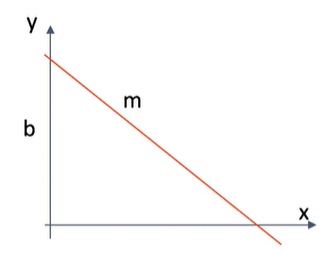

La línea también puede ser representada como:

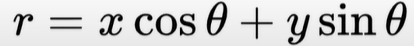

En donde **r** es la distancia desde el origen al punto más cercano de la línea recta.

**(r, θ)** corresponde al espacio de Hough que representa la línea.

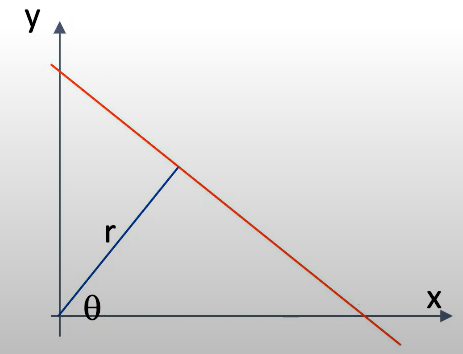

La representación anterior le permite al algoritmo considerar los parámetros de ángulo y distancia para así buscar la línea recta que mejor se ajusta a los puntos en el plano.

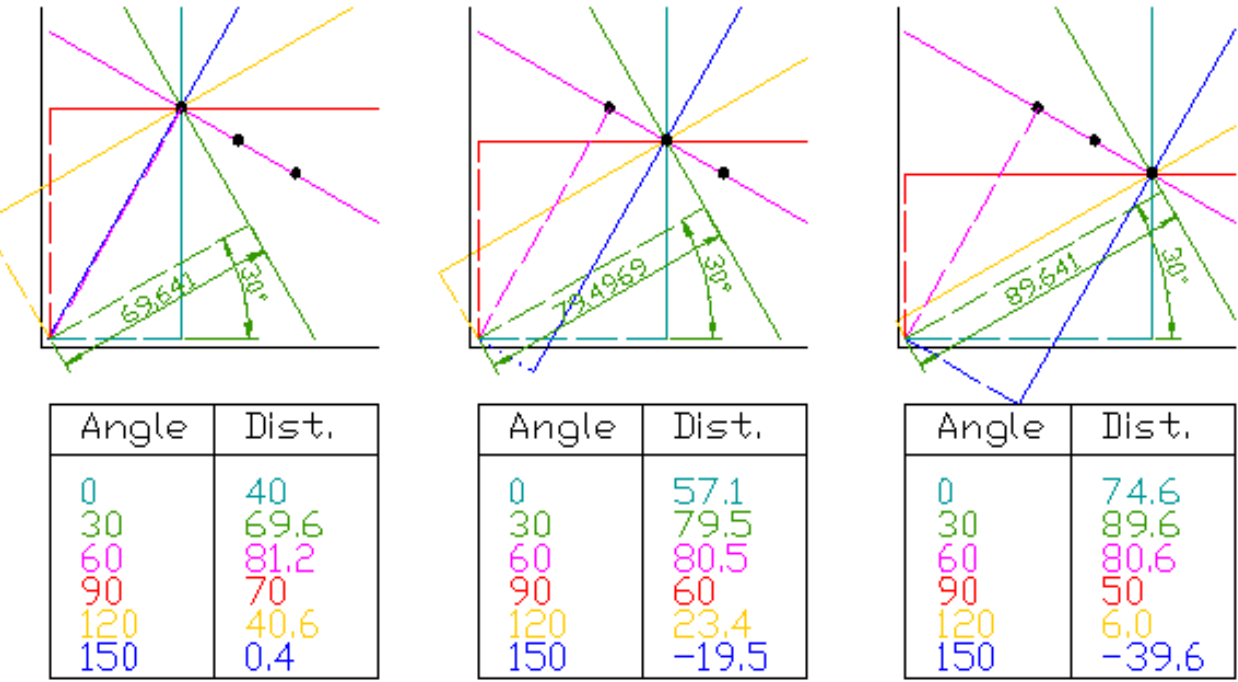

## Implementación usando scikit-image

#### skimage.transform.hough_line (image, theta=None)

**Parámetros de entrada:**
* **Imagen:** Imagen de entrada con valores no ceros que representan los bordes
* **Theta:** Ángulos sobre los cuales calcular la transformada, en radianes.

**Parámetros de salida:**
* **hspace:** Acumulador de la transformada de Hough (2-D ndarray uint64).
* **Ángulos:** Ángulos que calculan la transformada, en radianes.
* **Distancias:** Valores de distancia (ndarray)


**Referencia:** https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line

#### skimage.transform.hough_line_peaks(hspace, angles, dists, min_distance=9, min_angle=10, threshold=None, num_peaks=inf)

**Parámetros de entrada:**
* **hspace:** Espacio de Hough de salida de la función ```hough_line```.
* **Ángulos:** Ángulos de salida de salida de la función ```hough_line```.
* **Distancia:** Distancias de salida de salida de la función ```hough_line```.

**Parámetros de salida:**
* **accum, ángulos, distancias:** (tupla de arreglos) Valores pico en el espacio de Hough, ángulos y distancias.


**Referencia:** https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line_peaks

In [1]:
from skimage.transform import hough_line, hough_line_peaks
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import math

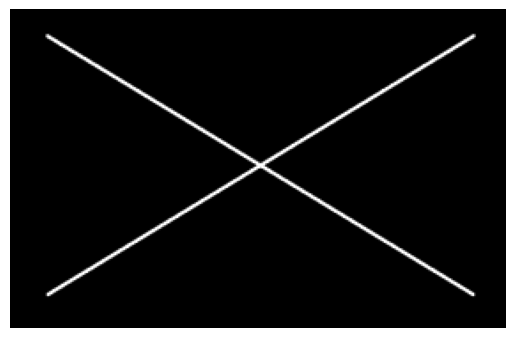

In [2]:
imagen = cv2.imread("lineas.png", 0)
imagen = ~imagen
plt.imshow(imagen, cmap="gray")
plt.axis("off");

In [3]:
# Dividimos el espacio de datos en 180 puntos

angulos = np.linspace(-np.pi/2, np.pi/2, 180)
len(angulos)

180

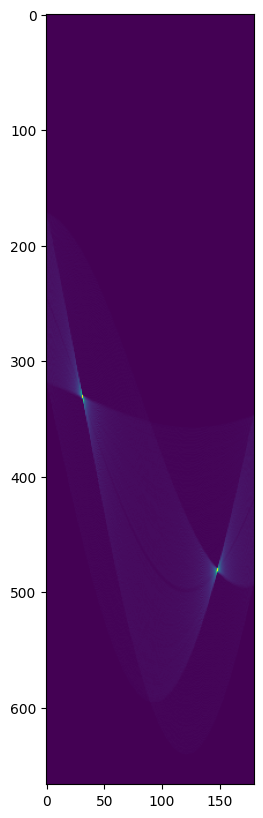

In [4]:
hspace, theta, dist = hough_line(imagen, angulos)

plt.figure(figsize=(10,10))
plt.imshow(hspace);

In [5]:
# Ahora para conocer la localización de los picos en el espacio de hough podemos utilizar la función hough_line_peaks()

h, q, d = hough_line_peaks(hspace, theta, dist)

In [6]:
df = pd.DataFrame({"Hough Space": h, "Angles": q, "Distance": d})

In [7]:
df.head()

,Hough Space,Angles,Distance
0,285,-1.026722,-2.0
1,283,1.026722,149.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hough Space  2 non-null      uint64 
 1   Angles       2 non-null      float64
 2   Distance     2 non-null      float64
dtypes: float64(2), uint64(1)
memory usage: 176.0 bytes


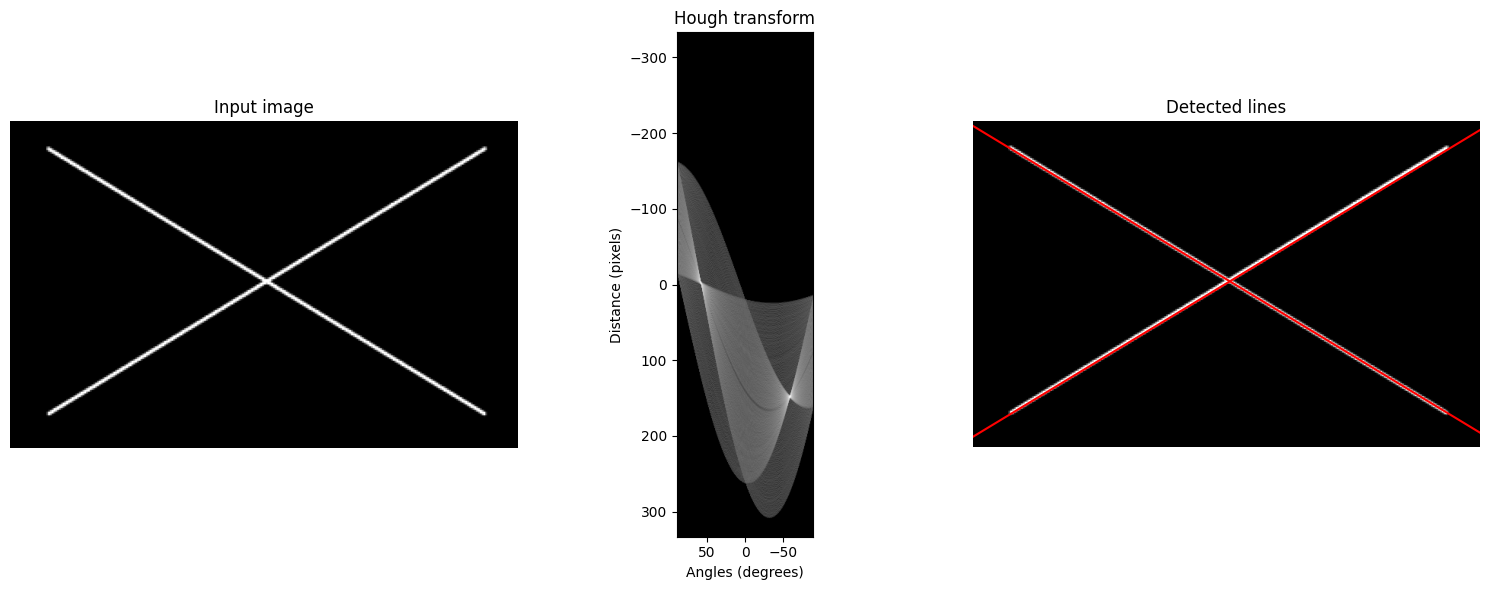

In [9]:
# Ejemplo de la documentación de skimage
angle_list=[] 

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(imagen, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + hspace),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), dist[-1], dist[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(imagen, cmap='gray')

origin = np.array((0, imagen.shape[1]))

for _, angle, dist in zip(*hough_line_peaks(hspace, theta, dist)):
    angle_list.append(angle) 
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((imagen.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

## Implementación usando OpenCV

#### HoughLines()

**Parámetros**

* **image:** Imagen de fuente binaria de un solo canal de 8 bits. La imagen puede ser modificada por la función
* **líneas:**  vector de salida de líneas. Cada línea está representada por un vector de 2 o 3 elementos (ρ,θ) o (ρ,θ,votos), donde ρ es la distancia desde el origen de coordenadas (0,0) (esquina superior izquierda de la imagen), θ es el ángulo de rotación de la línea en radianes (0∼línea vertical, π/2∼línea horizontal), y votos es el valor del acumulador.
* **rho:** Resolución de distancia del acumulador en píxeles.
* **theta:** Resolución del ángulo del acumulador en radianes.
* **umbral:** Parámetro de umbral del acumulador. Solo se devuelven aquellas líneas que obtienen suficientes votos ( >umbral ).
* **srn:** Para la transformada de Hough multiescala, es un divisor para la resolución de distancia rho. La resolución aproximada de la distancia del acumulador es rho y la resolución precisa del acumulador es rho/srn. Si tanto srn=0 como stn=0, se utiliza la transformada clásica de Hough. De lo contrario, ambos parámetros deberían ser positivos.
* **stn:** Para la transformada de Hough multiescala, es un divisor para la resolución de distancia theta.
* **min_theta:** Para transformada de Hough estándar y multiescala, ángulo mínimo para comprobar las líneas. Debe estar entre 0 y max_theta.
* **max_theta:** Para la transformada de Hough estándar y multiescala, un límite superior para el ángulo. Debe estar entre min_theta y CV_PI. El ángulo máximo real en el acumulador puede ser ligeramente menor que max_theta, dependiendo de los parámetros min_theta y theta.

**Referencia:** https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a

In [10]:
imagen_prueba = cv2.imread("tablero.jpg", 0)
dst = cv2.Canny(imagen_prueba, 50, 200, None, 3)

cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)
lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

In [11]:
len(lines)

29

In [12]:
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

In [13]:
def mostrar_imagenes(imagen_original, imagen_lineas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    ax1.imshow(imagen_original, cmap="gray")
    ax2.imshow(imagen_lineas)
    ax1.set_title("Imagen original")
    ax2.set_title("Tranformada de Hough")
    ax1.axis('off')
    ax2.axis('off');

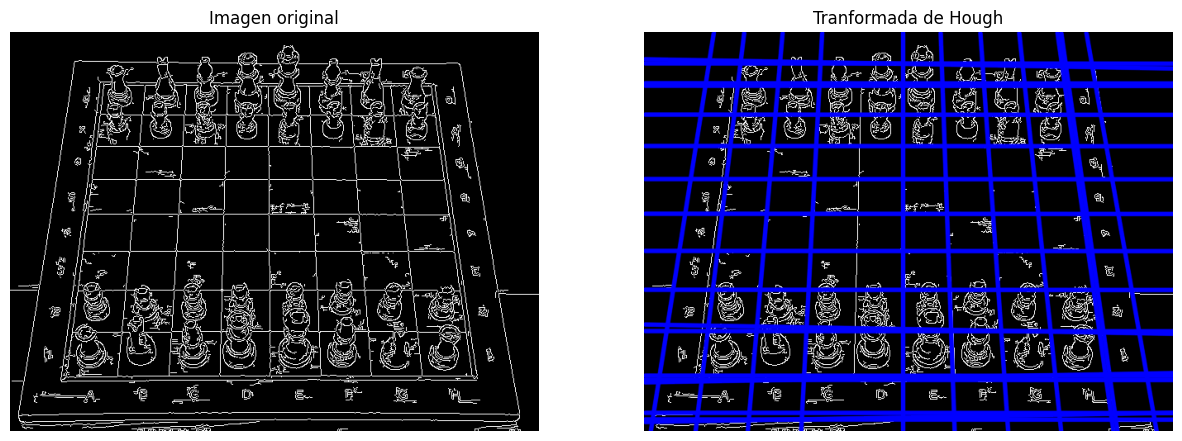

In [14]:
mostrar_imagenes(dst, cdst)

## Transformada de Hough Probabilística

#### HoughLinesP()

**Parámetros**

* **image:** Imagen de fuente binaria de un solo canal de 8 bits. La imagen puede ser modificada por la función.
* **líneas:** Vector de salida de líneas. Cada línea está representada por un vector de 4 elementos (x1,y1,x2,y2), donde (x1,y1) y (x2,y2) son los puntos finales de cada segmento de línea detectado.
* **rho:** Resolución de distancia del acumulador en píxeles.
* **theta:** Resolución del ángulo del acumulador en radianes.
* **umbral:** Parámetro de umbral del acumulador. Solo se devuelven aquellas líneas que obtienen suficientes votos ( >umbral ).
* **minLineLength:** Longitud de línea mínima. Los segmentos de línea más cortos que eso son rechazados.
* **maxLineGap:** Espacio máximo permitido entre puntos en la misma línea para unirlos.

**Referencia:** https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a

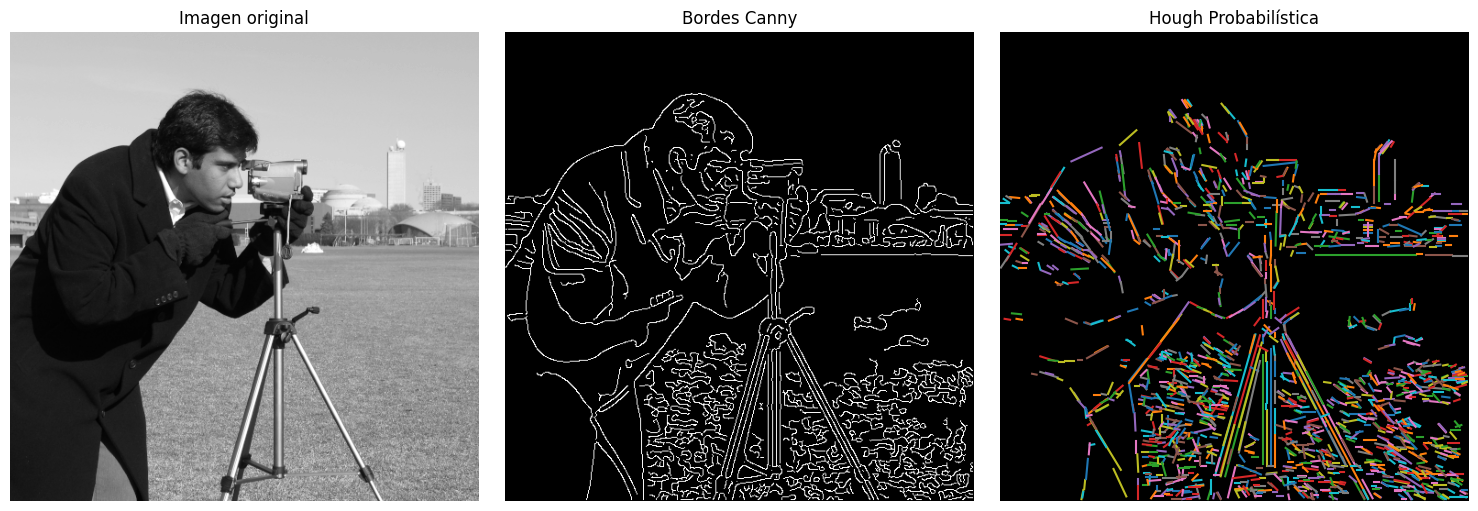

In [25]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
import skimage

image = skimage.data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Imagen original')

ax[1].imshow(edges, cmap="gray")
ax[1].set_title('Bordes Canny')

ax[2].imshow(edges * 0, cmap="gray")
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Hough Probabilística')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Hough Circle Transform

#### HoughCircles()

**Parámetros**

* **image:** Imagen de entrada en escala de grises, de un solo canal y de 8 bits.
* **círculos:** Vector de salida de los círculos encontrados. Cada vector está codificado como un vector de punto flotante de 3 o 4 elementos (x,y,radius) o (x,y,radius,votes) .
* **método:** Método de detección, consulte HoughModes. Los métodos disponibles son HOUGH_GRADIENT y HOUGH_GRADIENT_ALT.
* **dp:** Relación inversa de la resolución del acumulador a la resolución de la imagen. Por ejemplo, si dp=1, el acumulador tiene la misma resolución que la imagen de entrada. Si dp=2, el acumulador tiene la mitad de ancho y alto. Para HOUGH_GRADIENT_ALT el valor recomendado es dp=1.5, a menos que se necesiten detectar algunos círculos muy pequeños.
* **minDist:** Distancia mínima entre los centros de los círculos detectados. Si el parámetro es demasiado pequeño, se pueden detectar falsamente múltiples círculos vecinos además de uno verdadero. Si es demasiado grande, es posible que se pierdan algunos círculos.
* **param1:** Primer parámetro específico del método. En el caso de HOUGH_GRADIENT y HOUGH_GRADIENT_ALT, es el umbral más alto de los dos pasado al detector de borde Canny (el más bajo es dos veces más pequeño). Tenga en cuenta que HOUGH_GRADIENT_ALT utiliza el algoritmo de Scharr para calcular los derivados de la imagen, por lo que el valor de umbral normalmente debe ser más alto, como 300 o imágenes normalmente expuestas y contrastadas.
* **param2:** Segundo parámetro específico del método. En el caso de HOUGH_GRADIENT, es el umbral del acumulador para los centros del círculo en la etapa de detección. Cuanto más pequeño es, más círculos falsos se pueden detectar. Los círculos, correspondientes a los valores acumulados más grandes, se devolverán primero. En el caso del algoritmo HOUGH_GRADIENT_ALT, esta es la medida de "perfección" del círculo. Cuanto más se acerque a 1, mejor se seleccionará el algoritmo de círculos formados. En la mayoría de los casos, 0.9 debería estar bien. Si desea obtener una mejor detección de círculos pequeños, puede disminuirla a 0,85, 0,8 o incluso menos. Pero también intente limitar el rango de búsqueda [minRadius, maxRadius] para evitar muchos círculos falsos.
* **minRadius:** Radio mínimo del círculo.
* **maxRadius:** Radio máximo del círculo. Si <= 0, utiliza la dimensión máxima de la imagen. Si < 0, HOUGH_GRADIENT devuelve centros sin encontrar el radio. HOUGH_GRADIENT_ALT siempre calcula radios circulares.

**Referencia:** https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d

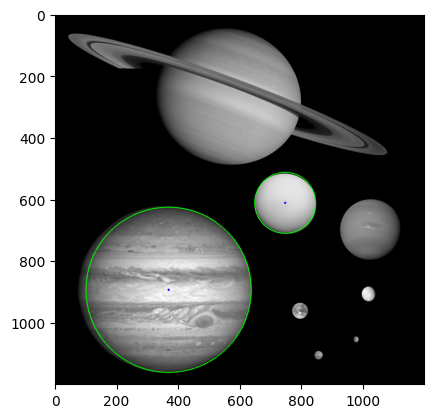

In [15]:
img = cv2.imread("planetas.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.medianBlur(img, 5)

cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT,1,20,
 param1=100,param2=95,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
 # draw the outer circle
 cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
 # draw the center of the circle
 cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)


plt.imshow(cimg);

**Referencias:**

[1] Straight line hough transform#. Straight line Hough transform - skimage 0.21.0 documentation. (n.d.). https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html#sphx-glr-auto-examples-edges-plot-line-hough-transform-py 

[2] Hough Line transform. OpenCV. (n.d.-b). https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html 